## Tugas Besar II IF3270 Pembelajaran Mesin - LSTM

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [24]:
import numpy as np
import pandas as pd
from customnn import LSTM, Embedded, FullyConnected
from keras import layers, models

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [3]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()

In [4]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])

In [9]:
models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.LSTM(units=64),
    layers.Dense(units=vocabs, activation='softmax')
])

models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1589 - loss: 7.9283 - val_accuracy: 0.3600 - val_loss: 7.7400
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4123 - loss: 7.5813 - val_accuracy: 0.3600 - val_loss: 6.9231
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3679 - loss: 6.7111 - val_accuracy: 0.3600 - val_loss: 5.8914
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4132 - loss: 5.6095 - val_accuracy: 0.3600 - val_loss: 4.6251
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3953 - loss: 4.3258 - val_accuracy: 0.3600 - val_loss: 3.3755
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3813 - loss: 3.1286 - val_accuracy: 0.3600 - val_loss: 2.3804
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3854 - loss: 2.2125 - val_accuracy: 0.3600 - val_loss: 1.7428
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3753 - loss: 1.6641 - val_accuracy: 0.3600 - val_loss: 1.4168


In [13]:
embedding_weights = models.layers[0].get_weights()[0]
lstm_weights = models.layers[1].get_weights()
kernel, recurrent_kernel, bias_lstm = lstm_weights
dense_weights = models.layers[2].get_weights()
kernel_dense, bias_dense = dense_weights

In [22]:
from sklearn.metrics import f1_score

class LSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=64, input_size=100, timestep=100, return_sequence=False)
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.lstm1.forward(self.embedding.forward(x)))
    
lstm_from_scratch = LSTMFromScratch(vocabs=vocabs)

lstm_from_scratch.embedding.weight = embedding_weights.copy()
lstm_from_scratch.lstm1.input_weights = kernel.copy()
lstm_from_scratch.lstm1.input_weights = np.split(lstm_from_scratch.lstm1.input_weights, 4, axis=1)
lstm_from_scratch.lstm1.hidden_weights = recurrent_kernel.copy()
lstm_from_scratch.lstm1.hidden_weights = np.split(lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
lstm_from_scratch.lstm1.bias = bias_lstm.copy()
lstm_from_scratch.lstm1.bias = np.split(lstm_from_scratch.lstm1.bias, 4)
lstm_from_scratch.fc1.weights = kernel_dense.copy()
lstm_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = models(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = lstm_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)

Difference: 2.0273187296035516e-08
F1: 1.0


In [25]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.LSTM(units=64)),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.2320 - loss: 7.9120 - val_accuracy: 0.3600 - val_loss: 7.6036
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3915 - loss: 7.3634 - val_accuracy: 0.3600 - val_loss: 6.2690
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3872 - loss: 5.8057 - val_accuracy: 0.3600 - val_loss: 4.2575
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3670 - loss: 3.7680 - val_accuracy: 0.3600 - val_loss: 2.2714
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3955 - loss: 1.9356 - val_accuracy: 0.3600 - val_loss: 1.3326
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3860 - loss: 1.2471 - val_accuracy: 0.3600 - val_loss: 1.1238
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3927 - loss: 1.1091 - val_accuracy: 0.4400 - val_loss: 1.0582
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3815 - loss: 1.0796 - val_accuracy: 0.4400 - val_loss: 1.0459

In [27]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_lstm_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_lstm, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_lstm_reverse = bi_lstm_weights
bi_dense_weights = bi_models.layers[2].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [29]:
class BiLSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=64, input_size=100, timestep=100, return_sequence=False, bidirectional=True)
        self.fc1 = FullyConnected(input_size=64, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.lstm1.forward(self.embedding.forward(x)))
    
bi_lstm_from_scratch = BiLSTMFromScratch(vocabs=vocabs)

bi_lstm_from_scratch.embedding.weight = bi_embedding_weights.copy()
bi_lstm_from_scratch.lstm1.input_weights = bi_kernel.copy()
bi_lstm_from_scratch.lstm1.input_weights = np.split(bi_lstm_from_scratch.lstm1.input_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights = bi_recurrent_kernel.copy()
bi_lstm_from_scratch.lstm1.hidden_weights = np.split(bi_lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias = bi_bias_lstm.copy()
bi_lstm_from_scratch.lstm1.bias = np.split(bi_lstm_from_scratch.lstm1.bias, 4)
bi_lstm_from_scratch.lstm1.input_weights_reverse = bi_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.input_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.input_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.hidden_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias_reverse = bi_bias_lstm_reverse.copy()
bi_lstm_from_scratch.lstm1.bias_reverse = np.split(bi_lstm_from_scratch.lstm1.bias_reverse, 4)
bi_lstm_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_lstm_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_lstm_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)

Difference: 1.3364437652109875e-05
F1: 1.0


In [31]:
# LSTM Models Hyperparameter Analysis
lstm_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128, return_sequences=True),
        layers.LSTM(units=256),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=32),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=128),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.LSTM(units=64)),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [32]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional"
]

1 Layer
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2481 - loss: 7.9090 - val_accuracy: 0.3600 - val_loss: 7.6188
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3601 - loss: 7.4215 - val_accuracy: 0.3600 - val_loss: 6.6458
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3952 - loss: 6.4192 - val_accuracy: 0.3600 - val_loss: 5.5550
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3823 - loss: 5.2858 - val_accuracy: 0.3600 - val_loss: 4.2751
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3764 - loss: 4.0115 - val_accuracy: 0.3600 - val_loss: 3.0830
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3871 - loss: 2.8667 - val_accuracy: 0.3600 - val_loss: 2.1768
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3707 - loss: 2.0438 - val_accuracy: 0.3600 - val_loss: 1.6248
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3891 - loss: 1.5606 - val_accuracy: 0.3600 - val_loss:

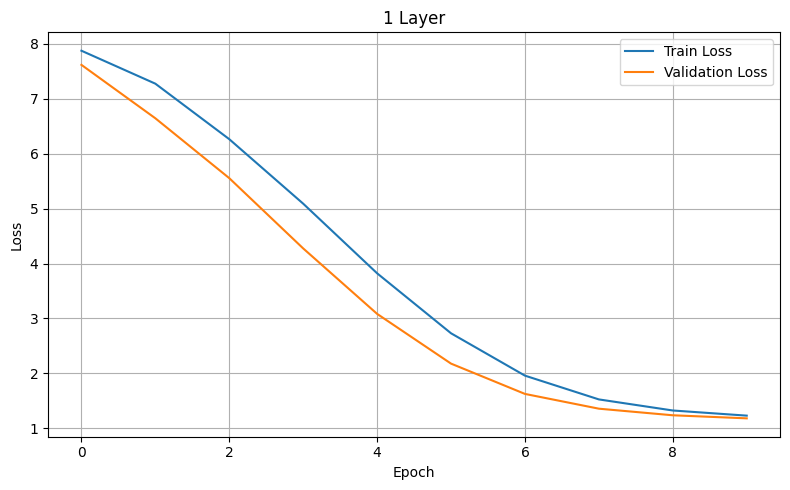


2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.2278 - loss: 7.8797 - val_accuracy: 0.3600 - val_loss: 7.0479
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3759 - loss: 6.6839 - val_accuracy: 0.3600 - val_loss: 5.2452
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3760 - loss: 4.7542 - val_accuracy: 0.3600 - val_loss: 3.0009
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3700 - loss: 2.6089 - val_accuracy: 0.3600 - val_loss: 1.5534
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3944 - loss: 1.4286 - val_accuracy: 0.3600 - val_loss: 1.1807
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4159 - loss: 1.1618 - val_accuracy: 0.3600 - val_loss: 1.1027
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3616 - loss: 1.1166 - val_accuracy: 0.4400 - val_loss: 1.0834
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3716 - loss: 1.1029 - val_accuracy: 0.4400 - val

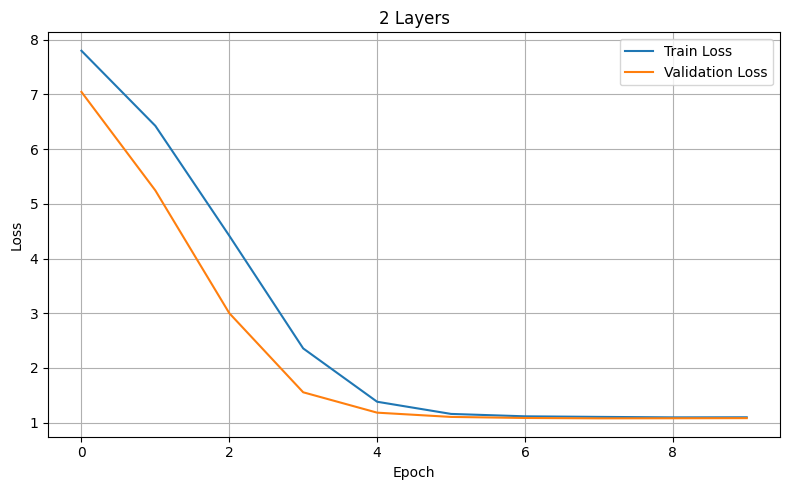


3 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.2048 - loss: 7.6947 - val_accuracy: 0.4400 - val_loss: 5.2132
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.3843 - loss: 4.3203 - val_accuracy: 0.4400 - val_loss: 1.6218
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.3585 - loss: 1.4190 - val_accuracy: 0.4400 - val_loss: 1.0835
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.3720 - loss: 1.0999 - val_accuracy: 0.4400 - val_loss: 1.0697
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.3807 - loss: 1.0835 - val_accuracy: 0.3600 - val_loss: 1.0656
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.3604 - loss: 1.0852 - val_accuracy: 0.3600 - val_loss: 1.0684
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.3751 - loss: 1.0843 - val_accuracy: 0.3600 - val_loss: 1.0679
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3837 - loss: 1.0788 - val_accuracy: 0.3600 -

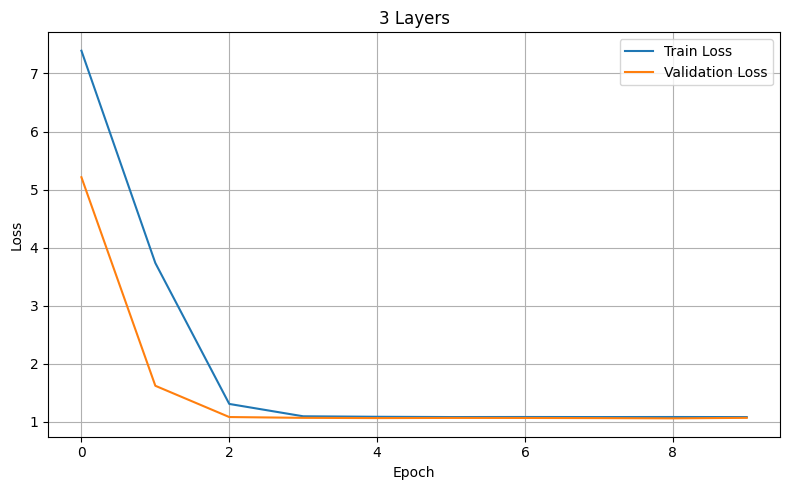


32 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.2654 - loss: 7.9126 - val_accuracy: 0.3600 - val_loss: 7.7336
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3751 - loss: 7.6498 - val_accuracy: 0.3600 - val_loss: 7.3379
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3823 - loss: 7.2270 - val_accuracy: 0.3600 - val_loss: 6.8375
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3992 - loss: 6.6982 - val_accuracy: 0.3600 - val_loss: 6.2343
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4005 - loss: 6.0753 - val_accuracy: 0.3600 - val_loss: 5.5727
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3851 - loss: 5.4155 - val_accuracy: 0.3600 - val_loss: 4.9221
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3924 - loss: 4.7721 - val_accuracy: 0.3600 - val_loss: 4.3178
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3841 - loss: 4.1798 - val_accuracy: 0.3600 - val_los

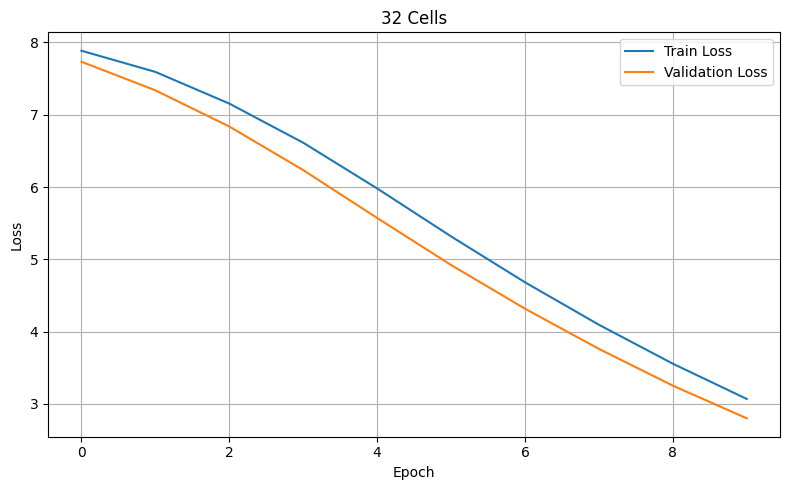


64 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1571 - loss: 7.9087 - val_accuracy: 0.4400 - val_loss: 7.5998
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4151 - loss: 7.4261 - val_accuracy: 0.3600 - val_loss: 6.7654
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3790 - loss: 6.5438 - val_accuracy: 0.4400 - val_loss: 5.7070
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3546 - loss: 5.4277 - val_accuracy: 0.4400 - val_loss: 4.4359
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3594 - loss: 4.1610 - val_accuracy: 0.4400 - val_loss: 3.2398
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3870 - loss: 3.0137 - val_accuracy: 0.4400 - val_loss: 2.2980
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3709 - loss: 2.1518 - val_accuracy: 0.4400 - val_loss: 1.6987
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3535 - loss: 1.6320 - val_accuracy: 0.4400 - val_los

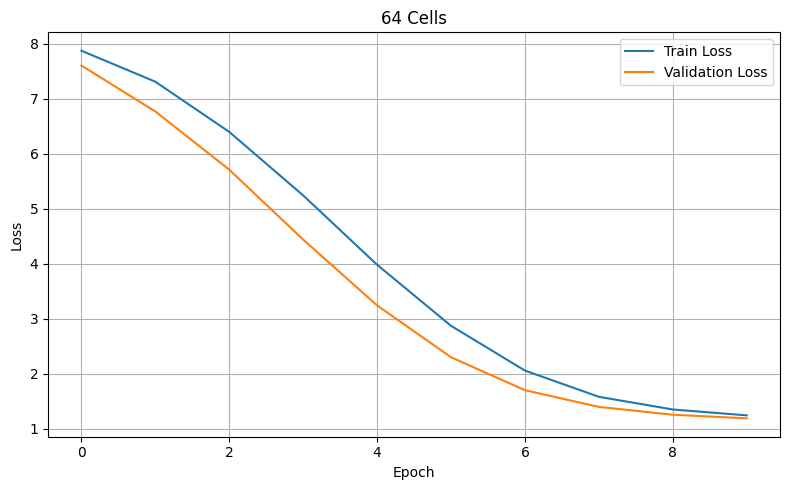


128 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.2417 - loss: 7.8751 - val_accuracy: 0.4400 - val_loss: 7.1006
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3745 - loss: 6.7069 - val_accuracy: 0.4400 - val_loss: 5.2195
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4066 - loss: 4.7357 - val_accuracy: 0.4400 - val_loss: 2.9405
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3896 - loss: 2.5505 - val_accuracy: 0.4400 - val_loss: 1.4815
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3794 - loss: 1.4077 - val_accuracy: 0.4400 - val_loss: 1.1479
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3897 - loss: 1.1446 - val_accuracy: 0.3600 - val_loss: 1.0990
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3806 - loss: 1.1107 - val_accuracy: 0.3600 - val_loss: 1.0962
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3535 - loss: 1.1107 - val_accuracy: 0.3600 - val_lo

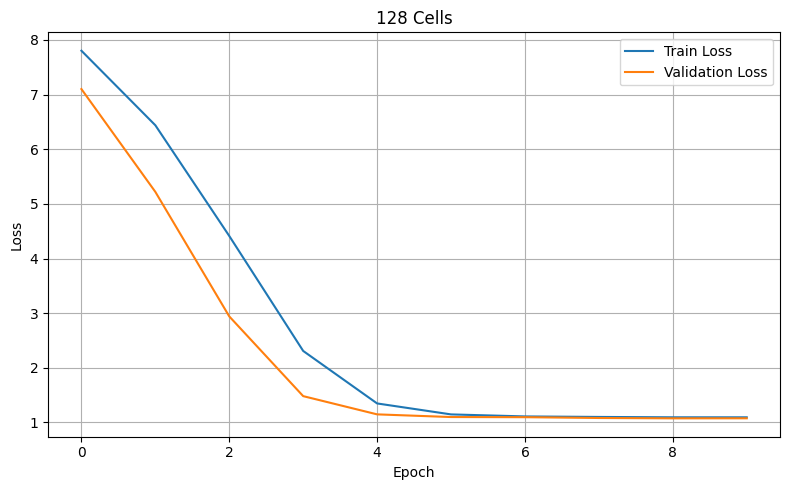


Unidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1768 - loss: 7.8995 - val_accuracy: 0.4400 - val_loss: 7.5668
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3744 - loss: 7.3928 - val_accuracy: 0.3600 - val_loss: 6.7300
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3935 - loss: 6.5073 - val_accuracy: 0.3600 - val_loss: 5.6686
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3901 - loss: 5.3866 - val_accuracy: 0.3600 - val_loss: 4.3942
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4057 - loss: 4.1074 - val_accuracy: 0.3600 - val_loss: 3.1866
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3501 - loss: 2.9578 - val_accuracy: 0.4400 - val_loss: 2.2537
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3849 - loss: 2.1023 - val_accuracy: 0.3600 - val_loss: 1.6727
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3997 - loss: 1.5986 - val_accuracy: 0.3600 - v

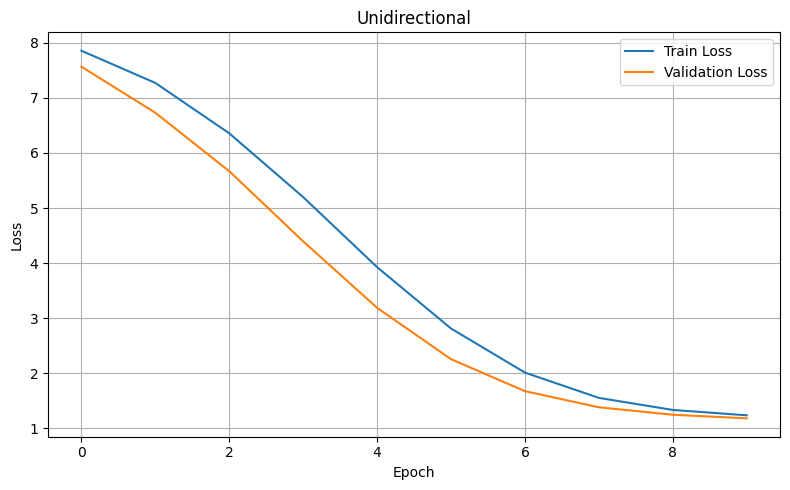


Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.2318 - loss: 7.8928 - val_accuracy: 0.3600 - val_loss: 7.4654
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3775 - loss: 7.1797 - val_accuracy: 0.4900 - val_loss: 6.0037
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4532 - loss: 5.5521 - val_accuracy: 0.4800 - val_loss: 3.9669
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4552 - loss: 3.4727 - val_accuracy: 0.3600 - val_loss: 2.0181
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3556 - loss: 1.7579 - val_accuracy: 0.3600 - val_loss: 1.2445
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3936 - loss: 1.1979 - val_accuracy: 0.3600 - val_loss: 1.1015
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3417 - loss: 1.1160 - val_accuracy: 0.4400 - val_loss: 1.0697
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3858 - loss: 1.0913 - val_accuracy: 0.3600 - v

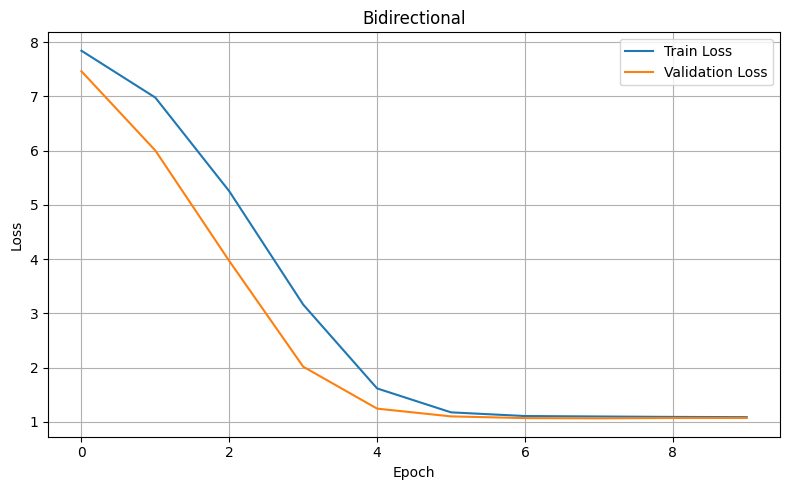

In [33]:
import matplotlib.pyplot as plt

n = 0

for model in lstm_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=10,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_test, y_test_int)

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

